In [1]:
from pandas import DataFrame, DatetimeIndex, read_csv, to_datetime
from datetime import timedelta
import numpy as np
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
df_weight = read_csv("PinaGewichtsdaten.csv", usecols=[1, 2])
df_weight["date"] = to_datetime(df_weight["date"], format="%Y-%m-%d %H:%M:%S.%f")
df_nutri = read_csv("PinaKaloriendaten.csv", usecols=[0, 1, 2, 3], 
                    dtype={"Tag": str, "Noom": float, "Lose It!": float, "Yazio": float})
df_nutri.rename(index=str, columns={"Tag": "date"}, inplace=True)
df_nutri["date"] = to_datetime(df_nutri["date"], format="%d.%m.%y")
df_nutri["Kalorien"] = df_nutri[["Noom", "Lose It!", "Yazio"]].mean(axis=1, skipna=True)
df_nutri["var"] = np.sqrt(df_nutri[["Noom", "Lose It!", "Yazio"]].var(axis=1, skipna=True))
df_nutri["date"] = df_nutri["date"] - timedelta(days=-1)
df_weight["diff"] = df_weight["weight"].diff()
df_weight = df_weight[df_weight["date"] > df_nutri["date"][-1]]

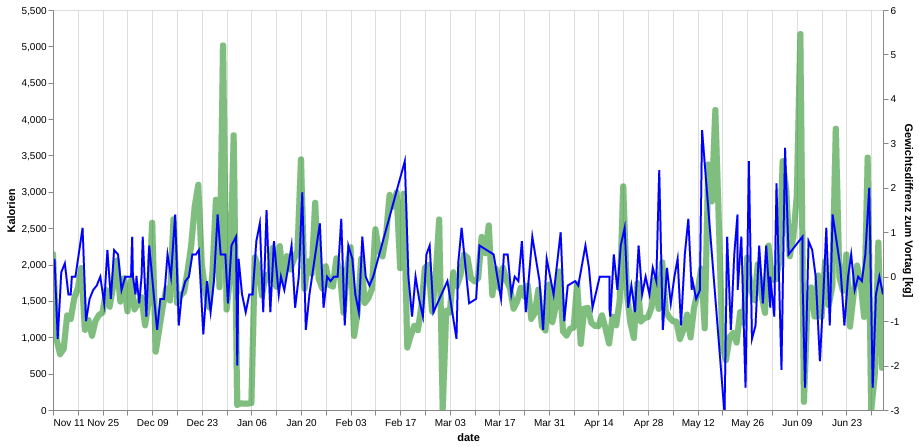

In [3]:
chart_nutri = alt.Chart(df_nutri).mark_line(
    color="green", interpolate='linear', shape='stroke', strokeCap='round', strokeJoin='round', strokeOpacity=0.5,
    strokeWidth=df_nutri["var"].mean()/df_nutri["Kalorien"].max()*400).encode(
    x='date', 
    y='Kalorien'
)
chart_weight = alt.Chart(df_weight).mark_line(color="blue").encode(
    x='date', 
    y=alt.Y('diff', 
            title="Gewichtsdiffrenz zum Vortag [kg]",
            scale=alt.Scale(zero=False, domain=(-3, 6), type='linear'))
)
double_chart = chart_nutri + chart_weight
double_chart = double_chart.resolve_scale(y='independent')
double_chart.properties(width=830, height=400).interactive(bind_x=True, bind_y=False)

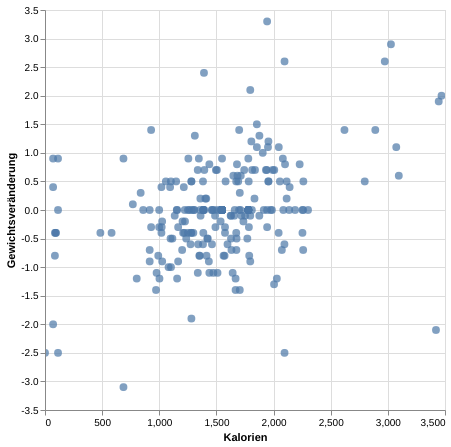

In [4]:
dw = df_weight.sort_values('date')[['date', 'diff']]
dw['date'] = DatetimeIndex(dw['date']).round(freq='D')
#d.merge(df_nutri.sort_values('date'))
dn = df_nutri.sort_values('date')[['date', 'Kalorien']]
dm = dn.merge(dw)

alt.Chart(dm).mark_circle(size=60).encode(
    x='Kalorien',
    y=alt.Y('diff', title="Gewichtsveränderung"),
    tooltip=['date']
).properties(width=400, height=400).interactive()

/home/pina/Code/Altair-examples/env/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:837: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


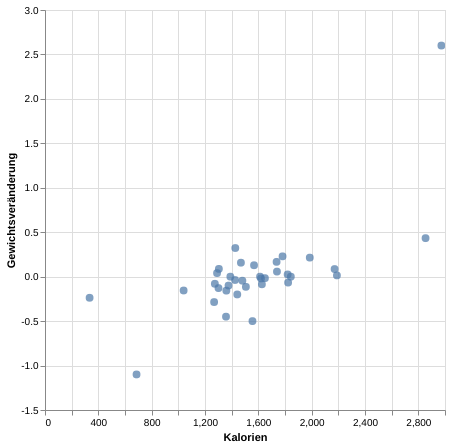

In [5]:
from pandas import DateOffset
dm['dg'] = dm['date'] - DateOffset(weekday=0, weeks=1)
dmm = dm.groupby(by='dg', as_index=False)[['date', 'Kalorien', 'diff']].mean()

alt.Chart(dmm).mark_circle(size=60).encode(
    x='Kalorien',
    y=alt.Y('diff', title="Gewichtsveränderung"),
    tooltip=['dg']
).properties(width=400, height=400).interactive()

In [6]:
dm['Kalorien'].mean()

1537.736559139785